## Observations and Insights

## Dependencies and starter code

In [514]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata = "data/Mouse_metadata.csv"
study_results = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata)
study_results = pd.read_csv(study_results)

# Combine the data into a single dataset
study_data_complete = pd.merge(study_results, mouse_metadata, how="left", on=["Mouse ID", "Mouse ID"])

## Summary statistics

In [515]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
describe_study_group = study_data_complete.groupby("Drug Regimen")
describe_study = describe_study_group.describe()[["Tumor Volume (mm3)"]]["Tumor Volume (mm3)"][["mean","std"]]
describe_study["var"] = describe_study["std"]**2
describe_study["sem"] = describe_study_group.sem()["Tumor Volume (mm3)"]
describe_study["med"] = describe_study_group.median()["Tumor Volume (mm3)"]

describe_study_summary = describe_study.rename(columns={"mean":"Average Tumor Size","std":"Standard Deviation","var":"Variance","sem":"SEM","med":"Median"})

describe_study_summary

,Average Tumor Size,Standard Deviation,Variance,SEM,Median
Drug Regimen,,,,,
Capomulin,40.675741,4.994774,24.947764,0.329346,41.557809
Ceftamin,52.591172,6.268188,39.290177,0.469821,51.776157
Infubinol,52.884795,6.567243,43.128684,0.492236,51.820584
Ketapril,55.235638,8.279709,68.553577,0.603860,53.698743
Naftisol,54.331565,8.134708,66.173479,0.596466,52.509285
Placebo,54.033581,7.821003,61.168083,0.581331,52.288934
Propriva,52.322552,6.507770,42.351070,0.512884,50.854632
Ramicane,40.216745,4.846308,23.486704,0.320955,40.673236
Stelasyn,54.233149,7.710419,59.450562,0.573111,52.431737


## Bar plots

Text(0, 0.5, 'Number of Data Points')

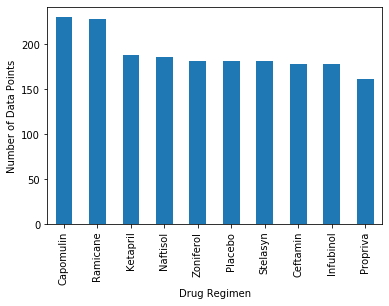

In [516]:
# Generate a bar plot showing number of data points for each treatment regimen using pandas
treatment_series = study_data_complete["Drug Regimen"].value_counts()
ax = treatment_series.plot(kind="bar")
ax.set_xlabel("Drug Regimen")
ax.set_ylabel("Number of Data Points")

In [517]:
# Generate a bar plot showing number of data points for each treatment regimen using pyplot


## Pie plots

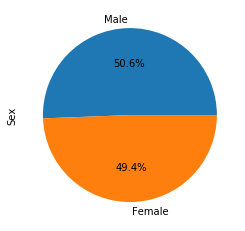

In [518]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
gender_series = study_data_complete["Sex"].value_counts()
ax = gender_series.plot(kind="pie", autopct="%1.1f%%")

([<matplotlib.patches.Wedge at 0x1627cf6ac50>,
 [Text(-0.02099250347258543, 1.0997996703027118, ''),
  Text(0.020992503472585782, -1.0997996703027118, '')])

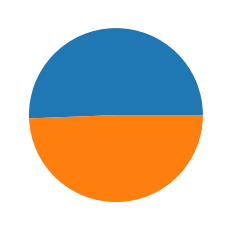

In [519]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(gender_series)

## Quartiles, outliers and boxplots

In [520]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. Calculate the IQR and quantitatively determine if there are any potential outliers. 
# All mice started with tumor volume of 45mm, I am using smallest average end tumor volume as a metric of drug effectiveness
end_tumor = study_data_complete[["Mouse ID", "Timepoint","Drug Regimen","Tumor Volume (mm3)"]].loc[study_data_complete["Timepoint"]==max(study_data_complete["Timepoint"])]
end_tumor_groupby = end_tumor.groupby("Drug Regimen")
ave_smallest_tumor_med = end_tumor_groupby.mean().nsmallest(4,"Tumor Volume (mm3)")
end_tumor_smallest = end_tumor.loc[end_tumor["Drug Regimen"].isin(ave_smallest_tumor_med.index)]

quantile_tumor_data = end_tumor_smallest.groupby("Drug Regimen")[["Tumor Volume (mm3)"]].quantile([.25,.5,.75]).unstack()

quantile_tumor_data.columns = quantile_tumor_data.columns.droplevel()

quantile_tumor_data["IQR"] = quantile_tumor_data[.75]-quantile_tumor_data[.25]
quantile_tumor_data["L_IQR"] = quantile_tumor_data[.25] - 1.5*quantile_tumor_data["IQR"]
quantile_tumor_data["U_IQR"] = quantile_tumor_data[.75] + 1.5*quantile_tumor_data["IQR"]

count = 0
for drug, row in quantile_tumor_data.iterrows():
    count += len(end_tumor_smallest.loc[(end_tumor_smallest["Drug Regimen"] == drug) &\
                                 ((end_tumor_smallest["Tumor Volume (mm3)"] < row["L_IQR"]) |\
                                 (end_tumor_smallest["Tumor Volume (mm3)"] > row["U_IQR"]))])
    
print(f"There are {count} outliers in {len(quantile_tumor_data)} Drug Regimens")

There are 0 outliers in 4 Drug Regimens


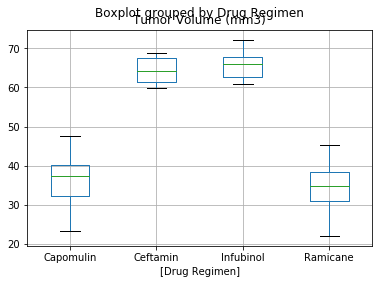

In [521]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
end_tumor_smallest[["Drug Regimen", "Tumor Volume (mm3)"]].sort_values("Drug Regimen").boxplot(by="Drug Regimen")

Text(0, 0.5, 'Tumor Volume\n(cubic millimeters)')

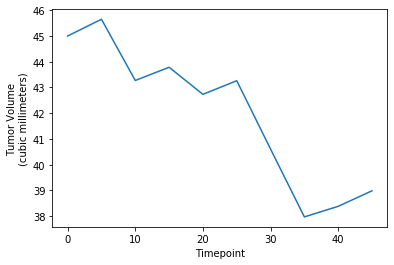

In [522]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
size_v_time = study_data_complete[["Timepoint", "Tumor Volume (mm3)"]].loc[study_data_complete["Mouse ID"]=="b128"].set_index("Timepoint")
size_v_time.plot(y = "Tumor Volume (mm3)", legend=None).set_ylabel("Tumor Volume\n(cubic millimeters)")

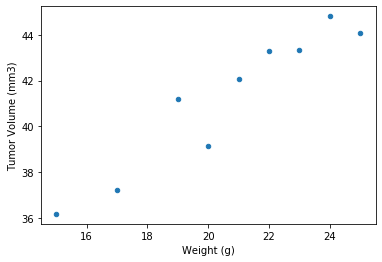

In [523]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
cap_weight_volume = study_data_complete[["Weight (g)", "Tumor Volume (mm3)"]].loc[study_data_complete["Drug Regimen"]=="Capomulin"]
cap_ave_weight_v_volume = cap_weight_volume.groupby("Weight (g)").mean()
cap_ave_weight_v_volume.reset_index(inplace=True)
cap_ave_weight_v_volume.plot(kind='scatter',x="Weight (g)",y="Tumor Volume (mm3)")

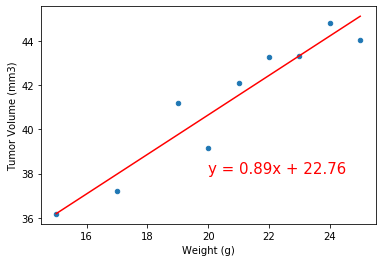

In [524]:
# Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen
x_values = cap_ave_weight_v_volume["Weight (g)"]
y_values = cap_ave_weight_v_volume['Tumor Volume (mm3)']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
cap_ave_weight_v_volume.plot(kind='scatter',x="Weight (g)",y="Tumor Volume (mm3)")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,38),fontsize=15,color="red")
plt.show()